In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from pysrc.zipper import *
from tqdm import tqdm

In [2]:
# See turorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# 1. Load the CIFAR-10 dataset
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transformTest = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transformTest)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


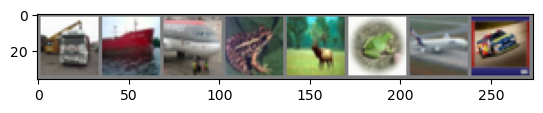

truck ship  plane frog  deer  frog  plane car  


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

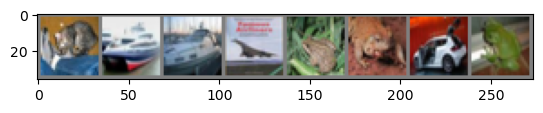

cat   ship  ship  plane frog  frog  car   frog 


In [4]:
# get some testing images
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [5]:
# 2. Define the fully connected neural network
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

class FCQuantNet(nn.Module):
    def __init__(self):
        super(FCQuantNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        self.relu6 = torch.nn.ReLU6()
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(1)
        
        self.quant = torch.ao.quantization.QuantStub(qconfig = None)
        self.dequant = torch.ao.quantization.DeQuantStub(qconfig = None)

        self.quant2 = torch.ao.quantization.QuantStub(qconfig = None)
        self.dequant2 = torch.ao.quantization.DeQuantStub(qconfig = None)

        self.quant3 = torch.ao.quantization.QuantStub(qconfig = None)
        self.dequant3 = torch.ao.quantization.DeQuantStub(qconfig = None)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.quant(x)
        x = self.dropout(self.relu6(self.fc1(x)))
        x = self.dequant(x)
        
        x = self.quant2(x)
        x = self.dropout(self.relu6(self.fc2(x)))
        x = self.dequant2(x)

        x = self.quant3(x)
        x = self.fc3(x)
        x = self.dequant3(x)
        x = self.softmax(x)
        return x
    
class ZLinNet(nn.Module):
    def __init__(self):
        super(ZLinNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 4000)
        self.fc3 = nn.Linear(4000, 1000)
        self.fc4 = nn.Linear(1000, 10)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.softmax(self.fc4(x))
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [ ]:
class ConvQuantNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [36]:
net = FCQuantNet()
device = torch.device("cpu") #torch.device("mps" if torch.backends.mps.is_available() else "cpu")
net.to(device)

net.eval()

net.qconfig = torch.ao.quantization.get_default_qat_qconfig('qnnpack')
torch.backends.quantized.engine = 'qnnpack'

model_fp32_prepared = torch.ao.quantization.prepare_qat(net.train())

In [39]:
# 4. Train the network
def fit(epochs, model, loss_func, opt, train_dl):
    print('Starting Training')
    model.train()
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        
        for input, label in train_dl:
            input = input.to(device)
            label = label.to(device)
            opt.zero_grad()
            output = model(input)
            loss = loss_func(output, label)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Train Loss: {running_loss/trainloader.__len__()}")

    print('Finished Training')

def training_loop(model, train_dl, loss_func = F.cross_entropy, epochs = 20, lr = 0.001):
    opt = optim.Adam(model.parameters(), lr=lr)
    fit(epochs, model, loss_func, opt, train_dl)

In [40]:
# 5. Test the network
def accuracy(model, test_dl):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data in tqdm(test_dl):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [41]:
training_loop(model_fp32_prepared, trainloader, epochs=10, lr=0.0001)
training_loop(model_fp32_prepared, trainloader, epochs=10, lr=0.00001)

Starting Training


 10%|█         | 1/10 [00:27<04:10, 27.78s/it]

Epoch 1, Train Loss: 2.102527689750847


 20%|██        | 2/10 [00:54<03:37, 27.16s/it]

Epoch 2, Train Loss: 2.0162045739190964


 30%|███       | 3/10 [01:20<03:06, 26.60s/it]

Epoch 3, Train Loss: 1.9842141766072539


 40%|████      | 4/10 [01:46<02:38, 26.50s/it]

Epoch 4, Train Loss: 1.964452642766411


 50%|█████     | 5/10 [02:13<02:13, 26.67s/it]

Epoch 5, Train Loss: 1.9475060847714125


 60%|██████    | 6/10 [02:41<01:47, 26.90s/it]

Epoch 6, Train Loss: 1.9311136598782161


 70%|███████   | 7/10 [03:08<01:21, 27.06s/it]

Epoch 7, Train Loss: 1.9185092305893179


 80%|████████  | 8/10 [03:35<00:53, 26.98s/it]

Epoch 8, Train Loss: 1.9056016824129598


 90%|█████████ | 9/10 [04:02<00:26, 26.96s/it]

Epoch 9, Train Loss: 1.8950825949459125


100%|██████████| 10/10 [04:29<00:00, 26.97s/it]


Epoch 10, Train Loss: 1.885285198688507
Finished Training
Starting Training


 10%|█         | 1/10 [00:27<04:08, 27.65s/it]

Epoch 1, Train Loss: 1.8576427164589961


 20%|██        | 2/10 [00:54<03:38, 27.32s/it]

Epoch 2, Train Loss: 1.8505092796767155


 30%|███       | 3/10 [01:23<03:14, 27.77s/it]

Epoch 3, Train Loss: 1.8470082151920288


 40%|████      | 4/10 [01:50<02:46, 27.68s/it]

Epoch 4, Train Loss: 1.8447246568282243


 50%|█████     | 5/10 [02:17<02:16, 27.26s/it]

Epoch 5, Train Loss: 1.8427481378435784


 60%|██████    | 6/10 [02:43<01:48, 27.10s/it]

Epoch 6, Train Loss: 1.8396854662834226


 70%|███████   | 7/10 [03:10<01:20, 26.98s/it]

Epoch 7, Train Loss: 1.8377563784189541


 80%|████████  | 8/10 [03:38<00:54, 27.11s/it]

Epoch 8, Train Loss: 1.8355784344551203


 90%|█████████ | 9/10 [04:05<00:27, 27.19s/it]

Epoch 9, Train Loss: 1.8333469670446938


100%|██████████| 10/10 [04:32<00:00, 27.21s/it]

Epoch 10, Train Loss: 1.8323990617261823
Finished Training


In [42]:
fit(5, model_fp32_prepared, F.cross_entropy, optim.SGD(model_fp32_prepared.parameters(), lr=0.0005, momentum=0.9), trainloader)

Starting Training


 20%|██        | 1/5 [00:24<01:36, 24.05s/it]

Epoch 1, Train Loss: 1.828811105254971


 40%|████      | 2/5 [00:48<01:12, 24.04s/it]

Epoch 2, Train Loss: 1.8280652839204539


 60%|██████    | 3/5 [01:12<00:48, 24.01s/it]

Epoch 3, Train Loss: 1.8278582489399045


 80%|████████  | 4/5 [01:36<00:24, 24.23s/it]

Epoch 4, Train Loss: 1.8270260037668526


100%|██████████| 5/5 [02:01<00:00, 24.20s/it]

Epoch 5, Train Loss: 1.826365606559207
Finished Training


In [43]:
model_fp32_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

In [44]:
accuracy(net, testloader)

100%|██████████| 157/157 [00:12<00:00, 12.31it/s]

Accuracy of the network on the 10000 test images: 11 %


In [45]:
accuracy(model_int8, testloader)

100%|██████████| 157/157 [00:12<00:00, 12.68it/s]

Accuracy of the network on the 10000 test images: 53 %


In [46]:
accuracy(model_fp32_prepared, testloader)

100%|██████████| 157/157 [00:12<00:00, 12.08it/s] 

Accuracy of the network on the 10000 test images: 53 %


In [61]:
model_int8.fc1.weight()

tensor([[ 0.0074, -0.0088,  0.0202,  ...,  0.0081,  0.0007, -0.0250],
        [-0.0121, -0.0007, -0.0135,  ..., -0.0047, -0.0027, -0.0135],
        [ 0.0297,  0.0013,  0.0256,  ...,  0.0108,  0.0162,  0.0317],
        ...,
        [ 0.0337,  0.0040,  0.0169,  ...,  0.0067,  0.0000,  0.0013],
        [ 0.0196,  0.0142,  0.0182,  ..., -0.0169, -0.0047, -0.0148],
        [ 0.0135,  0.0101, -0.0007,  ...,  0.0081,  0.0020,  0.0182]],
       size=(1000, 3072), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0006748862215317786,
       zero_point=0)

In [62]:
model_int8

FCQuantNet(
  (fc1): QuantizedLinear(in_features=3072, out_features=1000, scale=0.1949622929096222, zero_point=123, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=1000, out_features=500, scale=0.11991554498672485, zero_point=76, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=500, out_features=10, scale=0.22087779641151428, zero_point=157, qscheme=torch.per_tensor_affine)
  (relu6): QuantizedReLU6()
  (dropout): QuantizedDropout(p=0.1, inplace=False)
  (softmax): Softmax(dim=1)
  (quant): Quantize(scale=tensor([0.0078]), zero_point=tensor([127]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (quant2): Quantize(scale=tensor([0.0261]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant2): DeQuantize()
  (quant3): Quantize(scale=tensor([0.0261]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant3): DeQuantize()
)

6.59 0.8242365790453471


/Users/hongyihuang/Documents/GitHub/tensorzipper/pysrc/zipper.py:19: RuntimeWarning: divide by zero encountered in log2
  bits = np.log2(x)


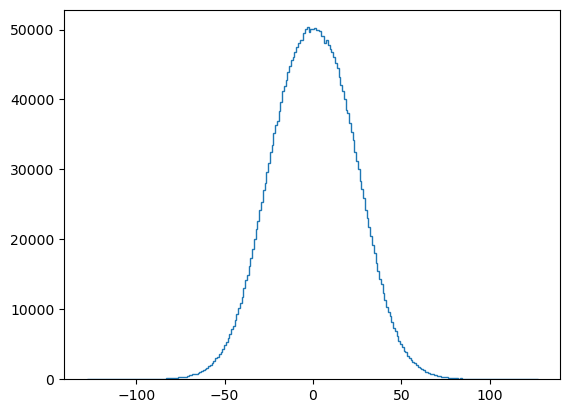

In [56]:
counts, bins = np.histogram(model_int8.fc1.weight().int_repr().detach().numpy(), bins=256)
plt.stairs(counts, bins)
print(round(theoreticalLimit(counts), 2), theoreticalLimit(counts)/8)

3.6 0.7201584589062338


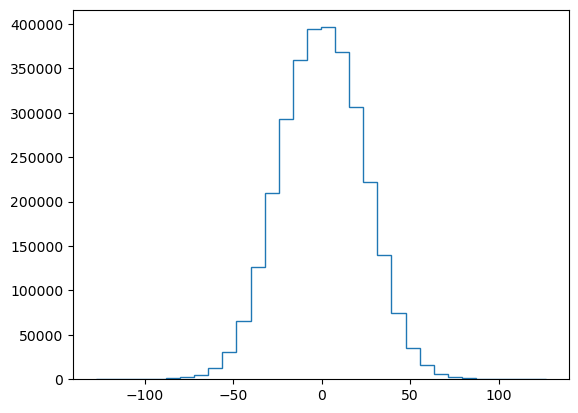

In [60]:
counts, bins = np.histogram(model_int8.fc1.weight().int_repr().detach().numpy(), bins=32)
plt.stairs(counts, bins)
print(round(theoreticalLimit(counts), 2), theoreticalLimit(counts)/5)

In [63]:
PATH = "./data/weights/cifar-fc.pt"

In [70]:
#save
model_scripted = torch.jit.script(model_int8) # Export to TorchScript
model_scripted.save(PATH) # Save

In [71]:
#load
model = torch.jit.load(PATH)
model.eval()

RecursiveScriptModule(
  original_name=FCQuantNet
  (fc1): RecursiveScriptModule(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
  (fc2): RecursiveScriptModule(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
  (fc3): RecursiveScriptModule(
    original_name=Linear
    (_packed_params): RecursiveScriptModule(original_name=LinearPackedParams)
  )
  (relu6): RecursiveScriptModule(original_name=ReLU6)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (softmax): RecursiveScriptModule(original_name=Softmax)
  (quant): RecursiveScriptModule(original_name=Quantize)
  (dequant): RecursiveScriptModule(original_name=DeQuantize)
  (quant2): RecursiveScriptModule(original_name=Quantize)
  (dequant2): RecursiveScriptModule(original_name=DeQuantize)
  (quant3): RecursiveScriptModule(original_name=Quantize)
  (dequant3): RecursiveScriptModule(original_name=DeQuantize)
)

In [74]:
model.fc1.scale

0.1949622929096222

In [14]:
net.conv1

AttributeError: 'FCNet' object has no attribute 'conv1'

In [ ]:
net.conv1.weight.shape

torch.Size([6, 3, 5, 5])

In [ ]:
net.conv1.bias.shape

torch.Size([6])

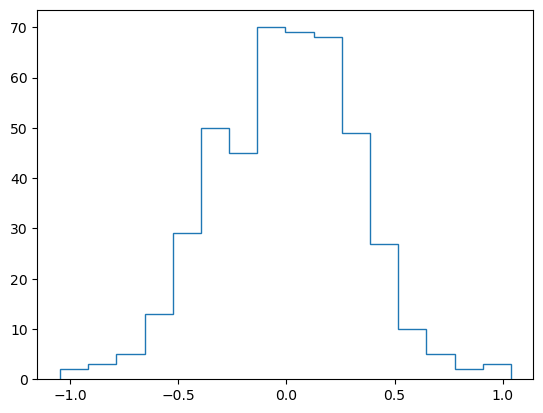

In [ ]:
counts, bins = np.histogram(net.conv1.weight.detach().numpy(), bins=16)
plt.stairs(counts, bins)

In [ ]:
theoreticalLimit(counts)/8

0.41943100508293435